# Example Project: Model Monitoring - Azure

**Problem Statement:** 

The objective is to analyze the relationship between advertising expenditures across different media sources, including TV, Radio, and Newspaper, and their impact on sales performance. The goal is to determine the optimal allocation of advertising budgets across these channels to maximize sales revenue. By examining the correlation between advertising expenditures and sales, the company aims to identify the most effective advertising strategies and make data-driven decisions to improve its marketing efforts. The insights gained from this analysis will enable the company to optimize resource allocation and develop a robust advertising strategy that aligns with its sales objectives.

Additionally, the business recognizes the need for ongoing model monitoring to ensure the effectiveness and accuracy of the advertising expenditure-to-sales relationship. By implementing a comprehensive model monitoring system, the company aims to continuously evaluate the performance of the advertising strategy and identify any potential deviations or shifts in the relationship. This will enable timely adjustments and optimizations to maintain the desired level of sales revenue.

### Create a compute cluster for jobs

In [3]:
#pip install azure.ai.ml
import azure.ai.ml

In [4]:
# Handle to the workspace
from azure.ai.ml import MLClient

# Authentication package
from azure.identity import DefaultAzureCredential

credential = DefaultAzureCredential()

In [5]:
# Get a handle to the workspace
ml_client = MLClient(
    credential=credential,
    subscription_id="8c0836c0-f63c-4878-aac9-0566796a0de8",
    resource_group_name="test-resource",
    workspace_name="demo_azureML",
)

In [6]:
# Get the workspace
from azureml.core import Workspace

ws = Workspace(subscription_id="8c0836c0-f63c-4878-aac9-0566796a0de8",
                resource_group="test-resource",
                workspace_name="demo_azureML")
print('Ready to work with', ws.name)

Ready to work with demo_azureML


In [16]:
from azure.ai.ml.entities import AmlCompute

# Name assigned to the compute cluster
cpu_compute_target = "cpu-cluster-preprocessing"

try:
    # let's see if the compute target already exists
    cpu_cluster = ml_client.compute.get(cpu_compute_target)
    print(
        f"You already have a cluster named {cpu_compute_target}, we'll reuse it as is."
    )

except Exception:
    print("Creating a new cpu compute target...")

    # Let's create the Azure ML compute object with the intended parameters
    cpu_cluster = AmlCompute(
        name=cpu_compute_target,
        # Azure ML Compute is the on-demand VM service
        type="amlcompute",
        # VM Family
        size="Standard_D2_v3",
        # Minimum running nodes when there is no job running
        min_instances=0,
        # Nodes in cluster
        max_instances=1,
        # How many seconds will the node running after the job termination
        idle_time_before_scale_down=180,
        # Dedicated or LowPriority. The latter is cheaper but there is a chance of job termination
        tier="Dedicated",
    )
    print(
        f"AMLCompute with name {cpu_cluster.name} will be created, with compute size {cpu_cluster.size}"
    )
    # Now, we pass the object to MLClient's create_or_update method
    cpu_cluster = ml_client.compute.begin_create_or_update(cpu_cluster)

You already have a cluster named cpu-cluster-preprocessing, we'll reuse it as is.


### Define and create an environment 

In [7]:
import os

## Set the name of the directory we want to create
dependencies_dir = "./env"

# # The os.makedirs() function creates a directory
# exist_ok=True means that the function will not raise an exception if the directory already exists
os.makedirs(dependencies_dir, exist_ok=True)

In [7]:
%%writefile {dependencies_dir}/conda.yaml
name: sklearn-env
channels:
  - conda-forge
dependencies:
  - python=3.8
  - pip=21.2.4
  - scikit-learn=0.24.2
  - scipy=1.7.1
  - pip:  
    - mlflow== 2.4.1
    - azureml-mlflow==1.42.0
    - azureml-inference-server-http

Overwriting ./env/conda.yaml


In [9]:
# Import the Environment class from the azure.ai.ml.entities module
from azure.ai.ml.entities import Environment

# Set the name of the custom environment we want to create
custom_env_name = "visa_preprocessing_env"

# Create an Environment object with the specified properties
job_env = Environment(
    name=custom_env_name,
    description="Custom environment for mid-term project",
    conda_file=os.path.join(dependencies_dir, "conda.yaml"),
    image="mcr.microsoft.com/azureml/openmpi4.1.0-ubuntu20.04:latest",
)
job_env = ml_client.environments.create_or_update(job_env)

# Print out some information about the registered environment
print(
    f"Environment with name {job_env.name} is registered to workspace, the environment version is {job_env.version}"
)

Environment with name visa_preprocessing_env is registered to workspace, the environment version is 5


In [8]:
# Getting the environment if it already exists
job_env = ml_client.environments.get(name="visa_preprocessing_env", label="latest")

### Create a processing script to perform the data preprocessing job

In [9]:
import os

src_dir = "./src"
os.makedirs(src_dir, exist_ok=True)

In [15]:
#pip install sklearn

In [26]:
#import mlflow

In [4]:
#import azureml

In [12]:
from sklearn import datasets

In [5]:
#print(azureml.core.VERSION)


1.51.0


In [9]:
#pip install --upgrade azureml-sdk

In [10]:
#pip install azureml-core

In [ ]:
# To use the training script, first create a directory where you will store the file.
# import os

# src_dir = "./src"
# os.makedirs(src_dir, exist_ok=True)

In [13]:
%%writefile {src_dir}/main.py

# importing necessary libraries
import argparse
import pandas as pd
import azureml.core
import numpy as np
import mlflow
import mlflow.sklearn
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingRegressor

def main():

    mlflow.start_run() # Start an MLflow run

    parser = argparse.ArgumentParser() # Create an argument parser
    parser.add_argument("--data", type=str)  # Add an argument for the data file path
    parser.add_argument("--learning-rate", required=False, default=0.1, type=float)
    parser.add_argument("--max-depth", required=False, default=4, type=float)
    parser.add_argument("--n-estimators", required=False, default=100, type=int)
    args = parser.parse_args()

    advertising = pd.read_csv(args.data)

    from sklearn.model_selection import train_test_split
    X = advertising.drop(columns=["Sales"])
    X = pd.get_dummies(X,drop_first=True)

    y = advertising["Sales"]

    X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
    )
    # Create a Gradient Boosting Regressor model with the specified hyperparameters
    model_gbr = GradientBoostingRegressor(
        n_estimators=args.n_estimators,
        learning_rate=args.learning_rate,
        max_depth=args.max_depth
    )


    model_gbr.fit(X_train, y_train)

    rmse = model_gbr.score(X_test, y_test)
    mse = model_gbr.score(X_test, y_test)

    mlflow.log_metric("RMSE", float(rmse))
    mlflow.log_metric("MSE", float(mse))

    # set the name for the registered model
    registered_model_name="advertising_decisiontree_model"

    print("Registering model pipeline")
     # Log the trained model to MLflow
    mlflow.sklearn.log_model(
        sk_model=model_gbr,
        registered_model_name=registered_model_name,
        artifact_path=registered_model_name
    )

    # # Saving the model to a file
    print("Saving the model via MLFlow")
    mlflow.sklearn.save_model(
        sk_model=model_gbr,
        path=os.path.join(registered_model_name, "trained_advertising_model"),
    )
    # End the MLflow run

    mlflow.end_run()


if __name__ == '__main__':
    main()



Overwriting ./src/main.py


### Configure the processing job

In [14]:
# Import the necessary modules
from azure.ai.ml import command
from azure.ai.ml import Input

# Define a new AML job using the `command` function
job = command(
    inputs=dict(
        data=Input(
            type="uri_file",
            #path="azureml:advertising_sales:1", # The path to the input data file from data asset
            path="./Data/Advertising_Sales.csv",
            #path="UI/2023-07-07_191924_UTC/Advertising_Sales.csv",
        )),
    # Specify the directory containing the code to be run in the job
    code="./src/",
    # Specify the command to be run in the job, including the input data and parameters as command line arguments
    command="python main.py --data ${{inputs.data}}",
    # Specify the environment to be used for the job
    environment="visa_preprocessing_env@latest",
    # Specify the compute target to be used for the job
    compute="cpu-cluster-preprocessing",
    # Specify the name of the experiment for the job
    experiment_name="train_advertising_sales",
     # Specify the display name for the job
    display_name="gbr_advertising_sales_prediction",
)

### Run the processing job

In [15]:
# ml_client.create_or_update will create a new job if it does not exist or update the existing job if it does
ml_client.create_or_update(job)

Uploading src (0.01 MBs): 100%|██████████| 7708/7708 [00:00<00:00, 177809.59it/s]




Experiment,Name,Type,Status,Details Page
train_advertising_sales,affable_bear_wqsdnnl9c6,command,Starting,Link to Azure Machine Learning studio


Bad pipe message: %s [b'O\xf8w\x91\xaf\x9f]:9\x84\xc8R\xd8\x8a\x94Nb\xf5 8_6\xd0h|\xfcV\x95\x06\xd2M\xa7\xc3=\xac7\x12\x06\x80\x9c\xc1\xc0\xe4\x1d7\xe0\xbaU\x93\xb5\xee\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00']
Bad pipe message: %s [b'\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05']
Bad pipe message: %s [b'\x03\x08']
Bad pipe message: %s [b'\x08\x08\t\x08\n\x08']
Bad pipe message: %s [b'\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06']
Bad pipe message: %s [b'']
Bad pipe message: %s [b'\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 \xae\xa1`B\x84X\xa8\xeck\xa8\xf4{\xa3B\x0e\x80Y\xac\x1d3\x01\xa6']
Bad pipe message: %s [b'\xcc\x7f\x85K\x94\xf8\xb4\xe9\x83\xf9"#\xd8\x8c<m\xf6\x0b ?\xc7\xbe3_\xd5/\x1d\xe4e\\\xc4']
Bad pipe message: %s [b"_\x93\xd4\xd2G\xb8\x92\xd7\xc9y2\xb0\x9d\x8eo\xbb\xd2\x9f\x00\x00|\x

**OBSERVATION**:  
* The gradient boosting model yielded a RMSE of only 0.982. This indicates high performance. The model is not only fitting the data, but generalizing over the test data very well.  

![model_metrics](./Data/model_metrics.png)

## Find and register the model

In [1]:
from azure.ai.ml.entities import Model
from azure.ai.ml.constants import AssetTypes, InputOutputModes

model_name = "advertising_decisiontree_model_v2"

model = Model(
    name=model_name,
    #The name of the MLflow model.
    path="advertising_best_model", # download model artifacts from azure, then upload to local
    #Path to the root directory of the model.
    type=AssetTypes.MLFLOW_MODEL,
    #The type of the model asset(MLflow model).
    description="MLflow model for the advertising regression problem",
    #The purpose of the model.
)


In [10]:
# Register the model
registered_model = ml_client.models.create_or_update(model=model)

Uploading advertising_best_model (0.2 MBs): 100%|██████████| 203527/203527 [00:00<00:00, 4098451.22it/s]




## Create Online Endpoint

#### Import the required libraries

In [11]:
# import required libraries
from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
    Model,
    Environment,
    CodeConfiguration,
)
from azure.ai.ml.constants import AssetTypes

#### Configure the endpoint:

Online endpoints are endpoints that are used for online (real-time) inferencing. Online endpoints contain deployments that are ready to receive data from clients and can send responses back in real time.

In [12]:
# Importing the required modules
import random
import string

# Creating a unique endpoint name by including a random suffix

# Defining a list of allowed characters for the endpoint suffix
allowed_chars = string.ascii_lowercase + string.digits

# Generating a random 5-character suffix for the endpoint name by choosing
# characters randomly from the list of allowed characters
endpoint_suffix = "".join(random.choice(allowed_chars) for x in range(5))

# Creating the final endpoint name by concatenating a prefix string
# with the generated suffix string
endpoint_name = "advertising-endpoint-" + endpoint_suffix

In [13]:
print(f"Endpoint name: {endpoint_name}")

Endpoint name: advertising-endpoint-pf8v9


#### Create the endpoint:

In [14]:
endpoint = ManagedOnlineEndpoint(
    name=endpoint_name,  
    # Name of the endpoint, should be unique within your deployment
    description="An online endpoint serving an MLflow model for the advertising prediction task",
    # A string describing the purpose of the endpoint
    auth_mode="key",
    # Authentication mode to use for the endpoint (in this case, using an API key)
    tags={"foo": "bar"},
    # A dictionary of key-value pairs that can be used to tag the endpoint
)

Using the `MLClient` created earlier, we will now create the Endpoint in the workspace. This command will start the endpoint creation and return a confirmation response while the endpoint creation continues.

In [15]:
ml_client.online_endpoints.begin_create_or_update(endpoint).result()

ManagedOnlineEndpoint({'public_network_access': 'Enabled', 'provisioning_state': 'Succeeded', 'scoring_uri': 'https://advertising-endpoint-pf8v9.eastus.inference.ml.azure.com/score', 'openapi_uri': 'https://advertising-endpoint-pf8v9.eastus.inference.ml.azure.com/swagger.json', 'name': 'advertising-endpoint-pf8v9', 'description': 'An online endpoint serving an MLflow model for the advertising prediction task', 'tags': {'foo': 'bar'}, 'properties': {'azureml.onlineendpointid': '/subscriptions/8c0836c0-f63c-4878-aac9-0566796a0de8/resourcegroups/test-resource/providers/microsoft.machinelearningservices/workspaces/demo_azureml/onlineendpoints/advertising-endpoint-pf8v9', 'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/8c0836c0-f63c-4878-aac9-0566796a0de8/providers/Microsoft.MachineLearningServices/locations/eastus/mfeOperationsStatus/oe:f50718ab-5901-4955-a8f2-f84baeb40e5b:63b6f2b6-427a-4edd-8a39-379b86aae6fe?api-version=2022-02-01-preview'}, 'print_as_yaml': True, 'i

## Create a blue deployment  
A deployment is a set of resources required for hosting the model that does the actual inferencing. We will create a deployment for our endpoint using the `ManagedOnlineDeployment` class.  This class allows user to configure key aspects.

#### Curating the deployment script:

In [16]:
%%writefile {src_dir}/score.py

# Import necessary libraries and modules
import logging
import os
import json
import mlflow
from io import StringIO
from mlflow.pyfunc.scoring_server import infer_and_parse_json_input, predictions_to_json

######################LOGGER#####################
# Set up Azure logging
import logging
from logging import Logger
from opencensus.ext.azure.log_exporter import AzureLogHandler

# Connect to Application Insights and set logging level to INFO
application_insights_connection_string= 'InstrumentationKey=5a3f9219-312f-46a1-a725-0e45f9321610;IngestionEndpoint=https://eastus-8.in.applicationinsights.azure.com/;LiveEndpoint=https://eastus.livediagnostics.monitor.azure.com/'
handler = AzureLogHandler(
connection_string=application_insights_connection_string)
logger = logging.getLogger()
logger.addHandler(handler)
logger.setLevel(logging.INFO)

####################################################

# Define the init() function to load the MLflow model
def init():
    global model
    global input_schema
    # "model" is the path of the mlflow artifacts when the model was registered. For automl
    # models, this is generally "mlflow-model".
    model_path = os.path.join(os.getenv("AZUREML_MODEL_DIR"), "advertising_best_model")
    model = mlflow.pyfunc.load_model(model_path)
    input_schema = model.metadata.get_input_schema()

# Define the run() function to make predictions using the loaded model
def run(raw_data):
    # Parse input data
    json_data = json.loads(raw_data)
    if "input_data" not in json_data.keys():
        raise Exception("Request must contain a top level key named 'input_data'")
    serving_input = json.dumps(json_data["input_data"])
    data = infer_and_parse_json_input(serving_input, input_schema)

    # Make predictions
    predictions = model.predict(data)

    # Log the input data and predictions to Azure
    logger.info("Data:{0},Predictions:{1}".format(str(data),str(predictions)))

    # Convert predictions to JSON format and return
    result = StringIO()
    predictions_to_json(predictions, result)
    return result.getvalue()

Overwriting ./src/score.py


#### Configure the deployment:

In [17]:
# Create a new deployment with name "blue"
blue_deployment = ManagedOnlineDeployment(
    name="blue",
    # Use the previously generated endpoint name
    endpoint_name=endpoint_name,
    # Use the registered model
    model=registered_model,
    # Use the latest environment named "machine_learning_E2E"
    environment="visa_preprocessing_env@latest",
    # Use the code in the "./src" directory and the "score.py" script
    code_configuration=CodeConfiguration(
        code="./src", scoring_script="score.py"
    ),
    # Use a single instance of type "Standard_E2s_v3"
    instance_type="Standard_E2s_v3",
    instance_count=1,
    # Enable Application Insights for the deployment
    app_insights_enabled=True,
)

#### Create the deployment:

Using the `MLClient` created earlier, we will now create the deployment in the workspace. This command will start the deployment creation and return a confirmation response while the deployment creation continues.

In [18]:
ml_client.online_deployments.begin_create_or_update(blue_deployment).result()

Check: endpoint advertising-endpoint-pf8v9 exists
Uploading src (0.01 MBs): 100%|██████████| 7628/7628 [00:00<00:00, 168075.35it/s]


data_collector is not a known attribute of class <class 'azure.ai.ml._restclient.v2022_02_01_preview.models._models_py3.ManagedOnlineDeployment'> and will be ignored


............................................................................................

ManagedOnlineDeployment({'private_network_connection': False, 'provisioning_state': 'Succeeded', 'data_collector': None, 'endpoint_name': 'advertising-endpoint-pf8v9', 'type': 'Managed', 'name': 'blue', 'description': None, 'tags': {}, 'properties': {'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/8c0836c0-f63c-4878-aac9-0566796a0de8/providers/Microsoft.MachineLearningServices/locations/eastus/mfeOperationsStatus/od:f50718ab-5901-4955-a8f2-f84baeb40e5b:19196c98-32b9-49a7-90cd-ccdde5e2f527?api-version=2022-02-01-preview'}, 'print_as_yaml': True, 'id': '/subscriptions/8c0836c0-f63c-4878-aac9-0566796a0de8/resourceGroups/test-resource/providers/Microsoft.MachineLearningServices/workspaces/demo_azureML/onlineEndpoints/advertising-endpoint-pf8v9/deployments/blue', 'Resource__source_path': None, 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/arandolph112661/code/Users/arandolph11266/mid-term-project/src/notebooks', 'creation_context': None, 'serialize': <m

## Test the deployment (using a "sample_data.json"file)

Using the `MLClient` created earlier, we will get a handle to the endpoint. The endpoint can be invoked using the invoke command.  
  
We will send a sample request using a "sample_data.json"file.

In [19]:
model_predictions_azure = ml_client.online_endpoints.invoke(
        endpoint_name=endpoint_name,# Specify the name of the endpoint to invoke
        deployment_name="blue",
        request_file="./Data/sample-request-sklearn.json"  # Provide the file containing the sample data for making predictions
)

In [43]:
model_predictions_azure

'"{\\"predictions\\": [22.248152393448706, 26.8968639301961, 22.248152393448706, 15.627089657691531, 16.767141131411734, 21.80791237254597, 26.847856510798234, 21.80791237254597, 15.728465035299328, 16.697504895506444, 22.201181401004696, 26.932760525897223, 22.33242823223803, 15.615003123354105, 16.686102378719912, 23.692626977314887, 26.932760525897223, 24.679497819344046, 15.728465035299328]}"'

In [46]:
# Convert the string representation of predictions to a Python data structure
import ast
model_predictions_azure_list = ast.literal_eval(model_predictions_azure)

In [47]:
len(model_predictions_azure_list)

392

In [37]:
model_predictions_azure_list

'{"predictions": [22.248152393448706, 26.8968639301961, 22.248152393448706, 15.627089657691531, 16.767141131411734, 21.80791237254597, 26.847856510798234, 21.80791237254597, 15.728465035299328, 16.697504895506444, 22.201181401004696, 26.932760525897223, 22.33242823223803, 15.615003123354105, 16.686102378719912, 23.692626977314887, 26.932760525897223, 24.679497819344046, 15.728465035299328]}'

In [21]:
# Access the converted Python data structure
model_predictions_azure_list_2 = ast.literal_eval(model_predictions_azure_list)
model_predictions_azure_list_2

{'predictions': [22.248152393448706,
  26.8968639301961,
  22.248152393448706,
  15.627089657691531,
  16.767141131411734,
  21.80791237254597,
  26.847856510798234,
  21.80791237254597,
  15.728465035299328,
  16.697504895506444,
  22.201181401004696,
  26.932760525897223,
  22.33242823223803,
  15.615003123354105,
  16.686102378719912,
  23.692626977314887,
  26.932760525897223,
  24.679497819344046,
  15.728465035299328]}

In [61]:

model_predictions_azure_list_3 = list(model_predictions_azure_list_2.values())

In [77]:
model_predictions_azure_list_3[0]

[22.248152393448706,
 26.8968639301961,
 22.248152393448706,
 15.627089657691531,
 16.767141131411734,
 21.80791237254597,
 26.847856510798234,
 21.80791237254597,
 15.728465035299328,
 16.697504895506444,
 22.201181401004696,
 26.932760525897223,
 22.33242823223803,
 15.615003123354105,
 16.686102378719912,
 23.692626977314887,
 26.932760525897223,
 24.679497819344046,
 15.728465035299328]

## Target Check

This is a very critical check especially when the ground truth is delayed. By comparing the distribution of the predictions with the target present in the training data, we can flag deviations beyond expected amount of variation.

In [22]:
#Access the training data
import pandas as pd
training_data = pd.read_csv("./Data/Advertising_Sales.csv")

In [42]:
training_data.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [54]:
training_data.shape

(200, 4)

#### Compare the distribution of predictions from the endpoint with the distribution of the target in the training data (Advertising.csv)

In [25]:
#pip install seaborn

In [48]:
#General imports required for testing
import json
import ast

import logging

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ks_2samp, chi2_contingency, ttest_rel

Note: Using plots state difference between the predictions coming from the endpoint and the distribution of targets in the training data. (Conclusion)

In the plots below, we compare the distribution of predictions from the endpoint logs with the distribution of the target in the training data.

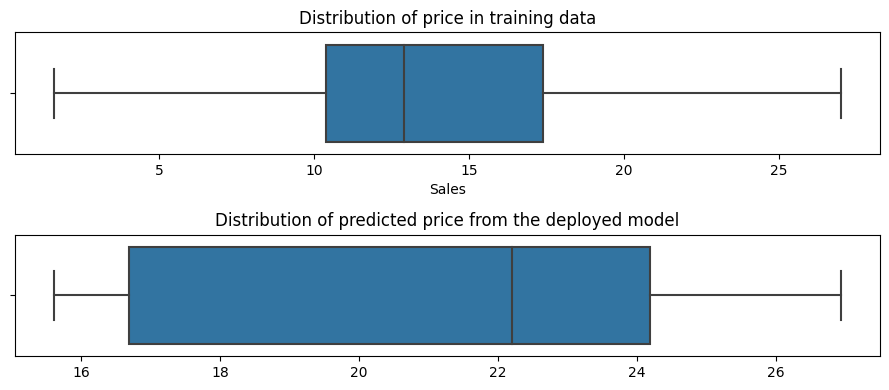

In [78]:
plt.figure(figsize=(9, 4))
plt.subplot(211)
sns.boxplot(x='Sales', data=training_data)
plt.title("Distribution of price in training data")
plt.subplot(212)
sns.boxplot(x=model_predictions_azure_list_3[0])
plt.title("Distribution of predicted price from the deployed model")
plt.tight_layout()

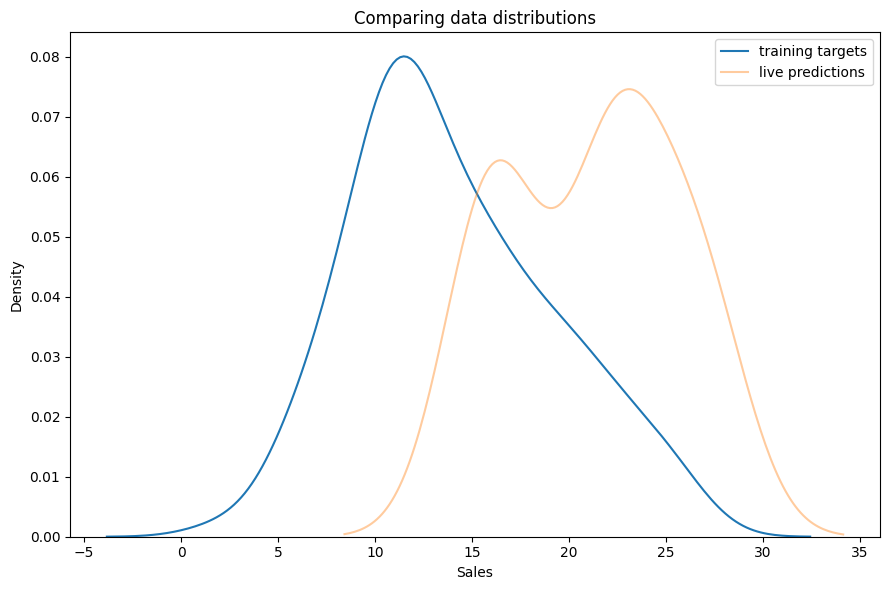

In [79]:
plt.figure(figsize=(9, 6))
sns.kdeplot(x='Sales', data=training_data, label='training targets')
sns.kdeplot(x=model_predictions_azure_list_3[0], label='live predictions', alpha=.4)
plt.legend()
plt.title('Comparing data distributions')
plt.tight_layout()

**OBSERVATION**:  
* Hmm. Looks like there has been a difference possibly the data between training and this live run.  
* The distributions are off a fair amount. 
* The box plots show this as well. Maybe there are a couple of outliers in the live targets.

#### Kolmogorov-Smirnov test:

To confirm the absence of target drift, we use the Kolmogorov-Smirnov (K-S) test. K-S test is a statistical method used to compare two probability distributions and determine if they significantly differ from each other. In the context of testing the difference between the distributions of model predictions and the distribution of targets in training data, the K-S test can help assess if there is any deviation or drift.

Plot here:

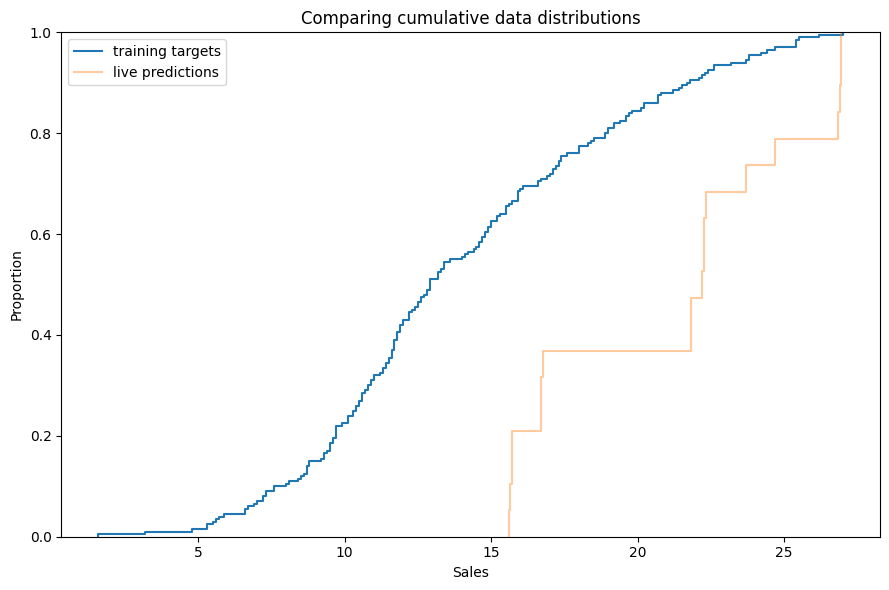

In [80]:
plt.figure(figsize=(9, 6))
sns.ecdfplot(x='Sales', data=training_data, label='training targets')
sns.ecdfplot(x=model_predictions_azure_list_3[0], label='live predictions', alpha=.4)
plt.legend()
plt.title('Comparing cumulative data distributions')
plt.tight_layout()

K-S Test:

In [81]:
statistic, p_value = ks_2samp(
            training_data["Sales"].values, 
            model_predictions_azure_list_3[0]
)

Note: Using p-value outcome, state difference between the model predictions and the target distribution in the training data

**OBSERVATION**:  
* With a p-value > 0.05, this suggests that there is **NO** significant difference between the model predictions and the target distribution in the training data.  
* There is no need to do any further analysis, but we will do it just for fun!


## Data Drift

We define data drift as the phenomenon of deviation or changes occurring between the distribution or characteristics of the training features and the corresponding live features used for real-time predictions or analysis. It indicates a shift in the underlying data generating process and can have significant implications for the performance and reliability of machine learning models or data-driven systems.  

Note: Use "advertising_synthetic.csv" to check for data drift

In [83]:
sample = pd.read_csv("./Data/advertising_synthetic.csv")

In [84]:
sample.shape

(49, 4)

In [85]:
sample.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [86]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         49 non-null     float64
 1   Radio      49 non-null     float64
 2   Newspaper  49 non-null     float64
 3   Sales      49 non-null     float64
dtypes: float64(4)
memory usage: 1.7 KB


In [87]:
threshold = 0.05
features_with_data_drift = []

In [88]:
target = "Sales"
numeric_features = ['TV', 'Radio', 'Newspaper']

In [89]:
for k, feature in enumerate(sample.columns):
    # Check if the feature is of numeric type
    # Perform the Kolmogorov-Smirnov test between the corresponding feature in the training and sample data
    if feature in numeric_features:
        statistic, p_value = ks_2samp(
            training_data[feature].values, 
            sample[feature].values
        )
        
        if p_value < threshold:
            features_with_data_drift.append(feature)

In [90]:
features_with_data_drift

[]

**OBSERVATION**:  
Note: Sate if data drift has been observed in a feature or not  
**There seems to be no data drift**


## Model Drift  

To confirm model drift, we compare the ground truth of live data with the predictions from the deployed model. This involves extracting samples where the predictions and ground truth are compared, followed by conducting a statistical test to determine if there is a significant difference between the model predictions and the ground truth.

For regression problems where the ground truth is readily available, we can compare the model's performance on a random sample with the ground truth observed in that sample. This comparison utilizes a paired two-sample t-test since the exact same sample is presented to both the deployed model and the ground truth. If the ground truth is not immediately available, we can estimate it manually and then compare the model's performance on the random sample with the manually estimated ground truth, again employing a paired two-sample t-test. In cases where manual estimation is not possible, we combine the ground truth (when available) with the predictions on the sample and perform a paired two-sample t-test for comparison.

Note: Use "advertising_ground_truth.csv" to check for Model drift

In [91]:
ground_truth_prices = pd.read_csv('./Data/advertising_ground_truth.csv')

In [92]:
len(ground_truth_prices)

19

In [96]:
ground_truth_prices

,Sales
0,22.1
1,10.4
2,9.3
3,18.5
4,12.9
5,7.2
6,11.8
7,13.2
8,4.8
9,10.6


In [99]:
# Perform a paired two-sample t-test
two_sample_ttest = ttest_rel(model_predictions_azure_list_3[0], ground_truth_prices['Sales'])
two_sample_ttest.pvalue

5.130255725567591e-05

Note: on the basis of p-value outcome state if there is significance difference between the model predictions and ground truth.

**OBSERVATION**:  
* Since p-value is much less than 0.05, we conclude that there **IS** evidence to suggest a difference between the model's predictions and ground truth.


### Delete the Endpoint

**Important!** An Endpoint is a LIVE node which is always running, ready to process & predict to give you output. So unless you are making real-time predictions on streaming data, delete your endpoints after use

In [46]:
ml_client.online_endpoints.begin_delete(name=endpoint_name)

...

### **SUMMARY**
This exercise showed how to create, train, and deploy a model's endpoint for serving. We then applied several monitoring techniques to confirm/deny data and/or model drift.  
Although there was no evidence of significant difference between the model predictions and the target distribution in the training data, we did find significant difference between the model's predictions and ground truth data.  
* This suggests that it may be time to re-train the model on the latest training data.  
* However, we will need to do a cost-benefit analysis to see if re-training will add business value.

### 